### 학생 성적 데이터
1. 시각화를 포함하여 자료 분석
2. 결측치를 식별하고 결측치를 예측
3. 범주형 변수 인코딩
4. 데이터 분할
5. svm, xgboost, randomforest 3개의 알고리즘을 이용하여 모델링

In [1]:
import pandas as pd
import numpy as np 
df = pd.read_csv("./data/student_data.csv")
df

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,GP,F,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,GP,F,no,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,GP,F,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,GP,F,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,GP,F,yes,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,yes,no,5.0,5.0,4.0,4.0,5.0,4.0,11.0,9,9,9
391,MS,M,no,no,2.0,4.0,5.0,3.0,4.0,2.0,3.0,15,14,16
392,MS,M,no,no,5.0,5.0,3.0,3.0,3.0,3.0,3.0,8,10,8
393,MS,M,no,no,4.0,4.0,1.0,3.0,4.0,5.0,0.0,11,11,12


1. EDA

In [2]:
## 데이터의 타입 확인 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   paid        395 non-null    object 
 3   activities  395 non-null    object 
 4   famrel      394 non-null    float64
 5   freetime    393 non-null    float64
 6   goout       392 non-null    float64
 7   Dalc        391 non-null    float64
 8   Walc        393 non-null    float64
 9   health      391 non-null    float64
 10  absences    392 non-null    float64
 11  grade       395 non-null    int64  
 12  G1          395 non-null    int64  
 13  G2          395 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 43.3+ KB


학생 성적 평균 : 10.660759493670886


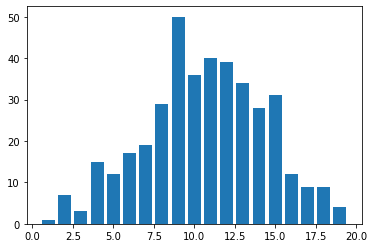

In [3]:
## 종속변수 분포 확인

import matplotlib.pyplot as plt

plt.bar(df['grade'].value_counts().index, df['grade'].value_counts().values)

print("학생 성적 평균 :", df["grade"].mean())

In [4]:
import scipy.stats as stats

stats.shapiro(df["grade"])

ShapiroResult(statistic=0.9871256351470947, pvalue=0.0014306077500805259)

종속변수 학생 성적에 대한 분포를 확인한 결과 평균 근처에 관측치가 많은 정규분포 형태를 띄었다. 
Shapriro test 결과도 p-value가 0.05이하로 정규성을 띄고 있음을 확인할 수 있었다. 

또한 해당 종속변수의 값이 정규성을 띄고 다양한 값이 있으므로 다중 classification으로 예측하는 것보다는 회귀분석을 진행하는 것이 좋아보인다. 

<AxesSubplot:>

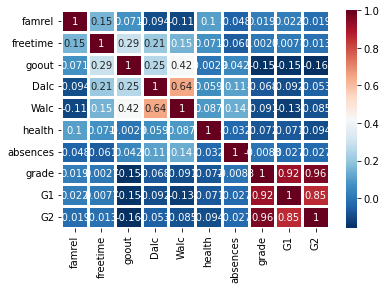

In [5]:
# 독립 변수 EDA
import seaborn as sns

df_cor = df.corr(method='pearson')
sns.heatmap(df_cor,
           xticklabels = df_cor.columns,
           yticklabels = df_cor.columns,
           cmap='RdBu_r',
           annot=True, 
           linewidth=3)

<BarContainer object of 2 artists>

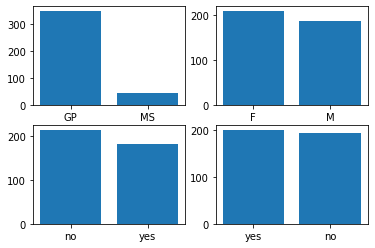

In [6]:
## 범주형 변수 시각화
fig, axs = plt.subplots(2,2)

axs[0][0].bar(df['school'].value_counts().index, df['school'].value_counts().values)

axs[0][1].bar(df['sex'].value_counts().index, df['sex'].value_counts().values)

axs[1][0].bar(df['paid'].value_counts().index, df['paid'].value_counts().values)

axs[1][1].bar(df['activities'].value_counts().index, df['activities'].value_counts().values)


In [7]:
## 전체 데이터에서 결측치 퍼센트 
df.isna().sum().sum()/(395*11)

0.004372842347525892

변수 해석 6가지 
 
1. 결측치 존재 여부 
- 전체 데이터에서 famrel, goout, Dalc, Walc, absences의 변수에서 결측치가 존재한다. 
- 결측치의 개수는 전체 1% 채 되지 않는 19개이다. 
- 결측치가 존재하는 변수들은 flat64형태로 평균으로 대체하거나 KNN을 사용할 수 있을 것으로 보인다. 

2. 데이터 타입 설명 
- 종속변수는 int형, 독립변수는 object와 float형태로 구성되어 있다. object타입은 인코딩을 통하여 변환해줄 필요가 있어보인다. 

3. 종속변수 분포 설명 
- 종속변수의 분포는 정규분포를 띈다. (위에서 설명함) 

4. 종속변수와 독립변수의 상관관계 설명 
- 종속변수 grade와의 상관계수를 확인해 보았을 때, 수치형 변수에서는 큰 상관성이 없었다. 파생변수를 활용할 필요가 있어보인다. 

5. 독립변수 상관관계 설명 
- 독립변수끼리의 상관관계를 확인해본 결과 다중공선성을 걱정할 만큼(0.9이상) 독립변수끼리의 상관성이 큰 변수는 보이지 않았다. 
- 하지만 G1과 G2의 관계는 서로 높으므로 주의할 필요가 있다. 

6. 유의할 점 (pandas_profiling의 warrning 값 설명) 
- 독립변수 중 school의 경우 비대칭성이 있으므로 주의하여야한다. 

2. 결측치 식별 및 결측치 예측

In [8]:
df[df.isna().any(axis=1)]

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
9,GP,M,yes,yes,5.0,5.0,NaN,1.0,1.0,5.0,0.0,15,14,15
14,GP,M,no,no,NaN,5.0,2.0,1.0,1.0,3.0,0.0,15,14,16
15,GP,F,no,no,4.0,4.0,4.0,1.0,2.0,2.0,NaN,14,14,14
25,GP,F,yes,no,1.0,2.0,2.0,1.0,NaN,5.0,14.0,8,6,9
39,GP,F,yes,yes,4.0,3.0,1.0,1.0,1.0,NaN,8.0,13,14,13
40,GP,F,no,yes,3.0,3.0,NaN,1.0,2.0,3.0,25.0,9,7,10
49,GP,F,no,yes,4.0,4.0,4.0,1.0,1.0,NaN,2.0,7,7,7
61,GP,F,no,yes,5.0,5.0,5.0,NaN,5.0,5.0,6.0,10,10,8
71,GP,M,no,no,3.0,3.0,3.0,NaN,1.0,3.0,0.0,10,10,10
82,GP,F,yes,no,4.0,4.0,4.0,1.0,1.0,5.0,NaN,6,7,6




1) 단순 대치법 : 수치형 변수라면, 각 컬럼의 평균이나 중앙값을 사용하여 결측치를 보간할 수 있으며, 
                 명목형, 범주형 변수라면 최빈값을 사용하여 대치할 수 있습니다. 
                 
2) KNN을 이용한 결측치 대체 : 보간법 중 결측치가 없는 컬럼들의 최근접 이웃 알고리즘을 통해 결측치가 있는 변수 대체를 할 수 있습니다. 
* 단, KNN을 이용할 때에는 거리 계산이 가능한 수치형 변수만 사용 가능 

- 해당 데이터에서는 한 행이 전부 결측치인 경우는 존재하지 않으므로 삭제보다는 대체하는 것이 좋아보인다. 수치형 변수만 결측치가 있으므로 KNN기법을 사용하여 대체하겠다. 


In [9]:
from sklearn.impute import KNNImputer
# 결측치가 있는 수치형 데이터만을 추출 
KNN_data = df.drop(columns=['school','sex','paid','activities'])

#모델링 
imputer = KNNImputer()
df_filled = imputer.fit_transform(KNN_data)
df_filled = pd.DataFrame(df_filled, columns=KNN_data.columns)
df[KNN_data.columns] = df_filled

#결측치 확인 
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
grade         0
G1            0
G2            0
dtype: int64

3. 범주형 변수 인코딩
- 이산형 변수 : school , sex ,paid,  activities 이 존재, 이산형 변수이므로 boolean 타입으로 변경하여 KNN을 이용한 결측치 처리와 머신러닝에서 변수사용가능하도록 변환하였다.
- 나머지 변수들은 수치 or 순위형 변수로 판단되므로 인코딩을 하지 않았다.

In [10]:
df = pd.get_dummies(data = df, columns=['school', 'sex', 'paid', 'activities'],drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   famrel          395 non-null    float64
 1   freetime        395 non-null    float64
 2   goout           395 non-null    float64
 3   Dalc            395 non-null    float64
 4   Walc            395 non-null    float64
 5   health          395 non-null    float64
 6   absences        395 non-null    float64
 7   grade           395 non-null    float64
 8   G1              395 non-null    float64
 9   G2              395 non-null    float64
 10  school_MS       395 non-null    uint8  
 11  sex_M           395 non-null    uint8  
 12  paid_yes        395 non-null    uint8  
 13  activities_yes  395 non-null    uint8  
dtypes: float64(10), uint8(4)
memory usage: 32.5 KB


4. 데이터 분할
- 해당 데이터는 종속변수가 연속형이므로, 회귀분석을 사용한다. 그러므로 층화추출기법을 사용한 분할이 아닌 랜덤 샘플링을 통한 분할을 사용하여, 7:3 비율로 분할하였다. 

In [11]:
X = df.drop('grade',axis=1)
y = df['grade']

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2022)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(276, 13)
(119, 13)
(276,)
(119,)


In [ ]:
!pip install xgboost

In [14]:
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

scaler = StandardScaler() 
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [15]:
## 매개변수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = [
    { 'C': [0.1, 1,10,100],'gamma': [0.001, 0.01, 0.1, 1, 10]}
]

grid_svm = GridSearchCV(SVR(), param_grid =param_grid, cv = 5)
grid_svm.fit(X_train_scaled, y_train)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,C,gamma,mean_test_score
15,100.0,0.001,0.960941
11,10.0,0.010,0.957198
16,100.0,0.010,0.947652
10,10.0,0.001,0.941800
6,1.0,0.010,0.921494
12,10.0,0.100,0.861286
17,100.0,0.100,0.857767
7,1.0,0.100,0.785883
5,1.0,0.001,0.303419
2,0.1,0.100,0.283644


In [16]:
svr = SVR(C=100, gamma = 0.001) 
svr.fit(X_train_scaled, y_train)

print("R2 : ", svr.score(X_test_scaled, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test,svr.predict(X_test_scaled))))

R2 :  0.9574163452579301
RMSE: 0.7753004545895915


In [17]:
## 비교적 간단하게 그리드서치를 이용하여 매개변수 적용
rf_grid = [
    { 'max_depth': [2,4,6,8,10], 'min_samples_split': [2, 4, 6, 8, 10]}
]

rf  = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid =rf_grid, cv = 5)
rf.fit(X_train, y_train)

print(rf.best_params_)
print("R2 : ", rf.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test,rf.predict(X_test))))

{'max_depth': 10, 'min_samples_split': 4}
R2 :  0.9546616809002921
RMSE: 0.7999839612844181


In [20]:
xgb_grid = [
    { 'max_depth': [2,4,6,8,10]}
]

xgb = GridSearchCV(XGBRegressor(n_estimators=1000), param_grid =xgb_grid, cv = 5)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

print("R2 : ", xgb.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test,xgb.predict(X_test))))

R2 :  0.963211004628444
RMSE: 0.7206220334000073


## 해석

- 가장적합한 알고리즘 선택 : XGBoost 모델이 가장 정확도가 높고 RMSE값이 낮으므로 예측 분석력이 좋다. 